In [62]:
import pandas as pd
import numpy as np

In [63]:
def load(file):
    """Load the experiment data from a CSV file with converter metrics."""
    
    schema = {
        'num_threads': np.int64(),
        'num_jsons_converted': np.int64(),
        'num_json_bytes_converted': np.int64(),
        'num_ipc': np.int64(),
        'ipc_bytes': np.int64(),
        'num_buffers_converted': np.int64(),
        't_parse': np.float64(),
        't_resize': np.float64(),
        't_serialize': np.float64(),
        't_thread': np.float64(),
        't_enqueue': np.float64(),
        'status': np.int64()
    }
    
    df = pd.read_csv(file, dtype=schema)

    # Make sure there were no errors for converters.
    assert(df['status'].sum() == len(df.index))
        
    return df

In [64]:
def analyze(df):
    """Analyze the experiment data, deriving various metrics such as throughput."""
    # Calculate time spent within the thread as 'other'.
    df['t_other'] = df['t_thread'] - df[['t_parse', 't_resize', 't_serialize', 't_enqueue']].sum(axis=1)
    
    # Calculate throughput
    df['Throughput (in)'] = df['num_json_bytes_converted'] / df['t_thread']
    df['Throughput (out)'] = df['ipc_bytes'] / df['t_thread']
    
    df['Parse throughput (in)'] = df['num_json_bytes_converted'] / df['t_parse']
    
    return df

In [65]:
def summarize(df):
    """Summarize the data from all threads into one row."""
    
    # num_threads,num_jsons_converted,num_json_bytes_converted,num_ipc,ipc_bytes,
    # num_buffers_converted,t_parse,t_resize,t_serialize,t_thread,t_enqueue,status
    
    row = {'Threads': df['num_threads'].sum(),
             'JSONs': df['num_jsons_converted'].sum(), 
             'Bytes (in)': df['num_json_bytes_converted'].sum(), 
             'IPC messages': df['num_ipc'].sum(),
             'IPC bytes': df['ipc_bytes'].sum(),
             'Buffers converted': df['num_buffers_converted'].sum(), 
             # Take the mean of the time spent in threads:
             'Parse time': df['t_parse'].mean(),
             'Resize time': df['t_resize'].mean(), 
             'Serialize time': df['t_serialize'].mean(), 
             'Enqueue time': df['t_enqueue'].mean(), 
             'Other time': df['t_other'].mean(),
             'Thread time': df['t_thread'].mean(), 
             'Throughput (in)': df['Throughput (in)'].sum(),
             'Throughput (out)': df['Throughput (out)'].sum(),
             'Parse throughput (in)': df['Parse throughput (in)'].sum()}
              
    return row;

In [75]:
import glob

csv_files = []
for file in glob.glob("../experiments/data/battery/latency/threads/metrics/custom/*.csv"):
    csv_files.append(file)

records = []
for file in csv_files:
    records.append(summarize(analyze(load(file))))


df = pd.DataFrame.from_records(records)

display(df)

df.sort_values(by=['Threads', 'JSONs'], inplace=True)
df = df[df.JSONs == df.JSONs.max()]

df.set_index('Threads', inplace=True)

display(df)

,Threads,JSONs,Bytes (in),IPC messages,IPC bytes,Buffers converted,Parse time,Resize time,Serialize time,Enqueue time,Other time,Thread time,Throughput (in),Throughput (out),Parse throughput (in)
0,30,1024,51072,960,257792,960,0.021801,0.000021,0.001002,0.000044,0.023738,0.046605,1.095641e+06,5.530652e+06,2.888904e+06
1,15,8388608,417314336,8640,573506816,480,0.205725,0.002097,0.020411,0.000176,0.053829,0.282238,1.478589e+09,2.031995e+09,2.053255e+09
2,16,16384,812128,512,1212928,512,0.014811,0.000020,0.000574,0.000173,0.012014,0.027593,2.944343e+07,4.397397e+07,6.349179e+07
3,6,131072,6482144,192,8899072,192,0.017457,0.000019,0.000689,0.000081,0.010247,0.028493,2.275007e+08,3.123264e+08,3.898508e+08
4,24,8192,402112,768,700416,768,0.021794,0.000021,0.000799,0.000112,0.016484,0.039210,1.025447e+07,1.786219e+07,2.161554e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,3,32768,1608992,96,2212352,96,0.007198,0.000014,0.000573,0.000102,0.003758,0.011645,1.382151e+08,1.900445e+08,2.349728e+08
507,13,1048576,52092864,1248,71593472,416,0.052004,0.000440,0.002781,0.000122,0.022551,0.077898,6.687368e+08,9.190741e+08,1.033580e+09
508,13,65536,3244000,416,4515584,416,0.014768,0.000017,0.000567,0.000049,0.011759,0.027160,1.194352e+08,1.662508e+08,2.451350e+08
509,22,16777216,834744832,16896,1147122176,704,0.267210,0.003044,0.034329,0.000176,0.073817,0.378577,2.204954e+09,3.030089e+09,3.171000e+09


,JSONs,Bytes (in),IPC messages,IPC bytes,Buffers converted,Parse time,Resize time,Serialize time,Enqueue time,Other time,Thread time,Throughput (in),Throughput (out),Parse throughput (in)
Threads,,,,,,,,,,,,,,
1,16777216,834744832,16384,1147022592,32,2.701090,0.026619,0.566423,0.002678,0.019730,3.316540,2.516915e+08,3.458492e+08,3.090400e+08
2,16777216,834744832,16384,1147022592,64,1.546830,0.014792,0.268051,0.002146,0.060635,1.892455,4.410910e+08,6.061030e+08,5.396583e+08
3,16777216,834744832,16416,1147028992,96,1.147450,0.011746,0.195481,0.001272,0.151051,1.507000,5.539116e+08,7.611340e+08,7.277019e+08
4,16777216,834744832,16384,1147022592,128,0.839389,0.010379,0.113243,0.000879,0.164213,1.128102,7.399548e+08,1.016772e+09,9.972923e+08
5,16777216,834744832,16480,1147041280,160,0.643032,0.007607,0.090056,0.000628,0.096688,0.838011,9.961027e+08,1.368767e+09,1.302197e+09
6,16777216,834744832,16512,1147047424,192,0.567098,0.006683,0.072453,0.000576,0.171195,0.818004,1.020465e+09,1.402251e+09,1.484418e+09
7,16777216,834744832,16576,1147060992,224,0.494895,0.005808,0.059008,0.000438,0.124128,0.684276,1.219895e+09,1.676314e+09,1.704389e+09
8,16777216,834744832,16384,1147022592,256,0.485038,0.005681,0.055482,0.000306,0.155813,0.702320,1.188553e+09,1.633191e+09,1.734117e+09
9,16777216,834744832,16416,1147028992,288,0.397875,0.005174,0.053689,0.000299,0.067159,0.524196,1.592430e+09,2.188170e+09,2.103104e+09


In [76]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

2.7564082687875064

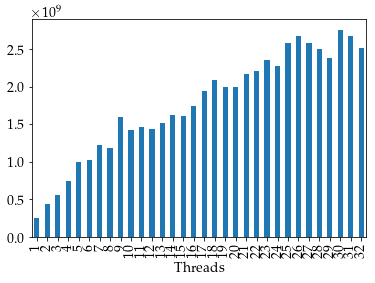

In [77]:
df['Throughput (in)'].plot.bar()
display(df['Throughput (in)'].max() * 1e-9)

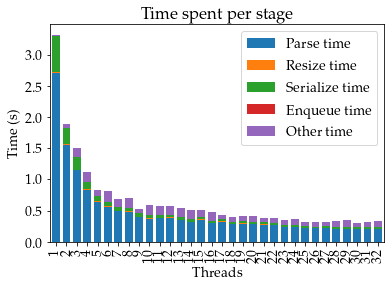

In [56]:
df_times = df[['Parse time', 'Resize time', 'Serialize time', 'Enqueue time', 'Other time']]
df_times.rename(columns={'Parse time': 'Parse', 
                         'Resize time': 'Resize', 
                         'Serialize time': 'Serialize', 
                         'Enqueue time': 'Enqueue', 
                         'Other time': 'Other'})
ax = df_times.plot.bar(stacked=True, 
                        width=0.75,
                        title='Time spent per stage',
                        ylabel='Time (s)')

In [57]:
from pywaffle import Waffle

wd = df_times.sum()

plt.figure(
    FigureClass=Waffle,
    rows=1,
    columns=100,
    values=wd,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}
)

plt.tight_layout()

wd

Parse time        15.230903
Resize time        0.166319
Serialize time     2.258313
Enqueue time       0.014405
Other time         3.281413
dtype: float64